In [253]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_excel('GBEL.xlsx', sheet_name='in')

# Drop unnecessary columns and handle missing values
df = df.drop(columns=['DataProvider', 'Unnamed: 38'])  # Keep 'StartTime' and 'SettlementDate' for reference

# Convert 'StartTime' to datetime to include both date and time
df['StartTime'] = pd.to_datetime(df['StartTime'])

# Define target variable: 
# Let's create a target column 'Action' where 1 = Buy, -1 = Sell, 0 = Hold based on price changes
df['PriceChange'] = df['Price(£/MWH)'].pct_change()
df['Action'] = df['PriceChange'].apply(lambda x: 1 if x > 0.01 else (-1 if x < -0.01 else 0))


# Features and target
# Include 'Price(£/MWH)' and 'PriceChange' as they might be important features for prediction
X = df.drop(columns=['Action', 'StartTime', 'SettlementDate'])
y = df['Action']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)





              precision    recall  f1-score   support

          -1       0.90      1.00      0.95        38
           0       1.00      0.38      0.55         8
           1       0.96      1.00      0.98        22

    accuracy                           0.93        68
   macro avg       0.95      0.79      0.82        68
weighted avg       0.93      0.93      0.91        68



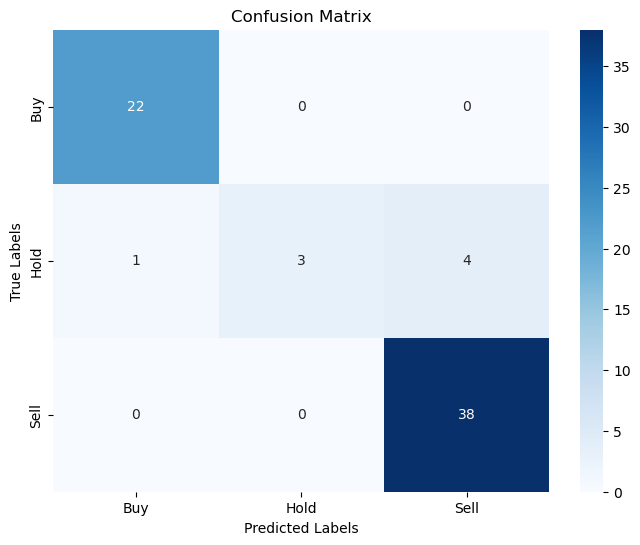

In [254]:
# Build a pipeline with StandardScaler and RandomForestClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42))  # Increased estimators and limited depth for better performance
])

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=[1, 0, -1])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['Buy', 'Hold', 'Sell'], yticklabels=['Buy', 'Hold', 'Sell'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



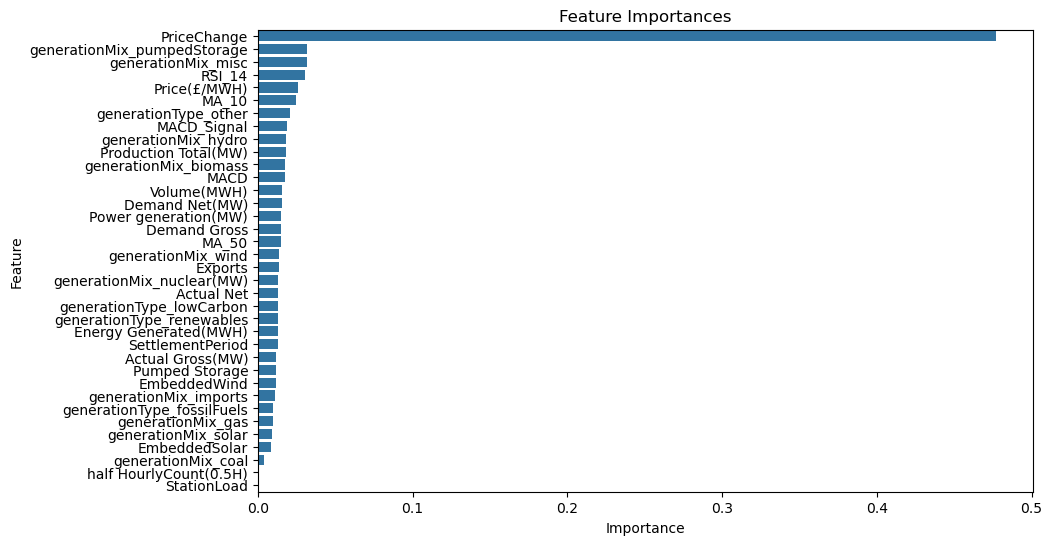

In [255]:
# Feature importance
importances = pipeline.named_steps['classifier'].feature_importances_
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [256]:
# Trading Strategy based on predictions
# Modify the trading_strategy function to include timestamps and details
# Improved trading strategy to optimize profitability

def trading_strategy(predictions, times, df):
    actions = []
    for i in range(len(predictions)):
        action = None
        if predictions[i] == 1:
            action = 'Buy'
        elif predictions[i] == -1:
            action = 'Sell'
        else:
            action = 'Hold'
        # Include the StartTime information with the action
        timestamp = df.loc[times[i], 'StartTime']
        price = df.loc[times[i], 'Price(£/MWH)']
        actions.append((timestamp, action, price))
    return actions

# Apply trading strategy
y_test_times = X_test.index  # Use the index to get the corresponding timestamps
y_test_actions = trading_strategy(y_pred, y_test_times, df)

# Display Buy and Sell actions in chronological order
print("Buy and Sell Actions in Chronological Order:")
y_test_actions_sorted = sorted([action for action in y_test_actions if action[1] != 'Hold'], key=lambda x: x[0])
for action in y_test_actions_sorted:
    print(f"Date & Time: {action[0]} - Action: {action[1]} - Price: £{action[2]:.2f}")

# Calculate profitability based on the actions of the model
initial_balance = 10000  # Initial balance in £
balance = initial_balance
position = 0  # Current position (positive for long, negative for short)

def calculate_profit_step_by_step(actions):
    actions_sorted = sorted(actions, key=lambda x: x[0])
    balance = initial_balance
    position = 0
    print("Step-by-Step Profit Calculations in Chronological Order:")
    for i in range(1, len(actions_sorted)):
        prev_action = actions_sorted[i - 1]
        current_action = actions_sorted[i]

        if prev_action[1] == 'Buy' and current_action[1] == 'Sell':
            # Sell the position
            profit = position * current_action[2]
            balance += profit
            position = 0
            print(f"Sold at £{current_action[2]:.2f}")
            print(f"Calculation: Profit = Position ({position:.2f}) * Sell Price ({current_action[2]:.2f}) = £{profit:.2f}")
            print(f"New Balance: £{balance:.2f}")
        elif prev_action[1] == 'Sell' and current_action[1] == 'Buy':
            # Close the short position
            profit = position * (2 * prev_action[2] - current_action[2])
            balance += profit
            position = 0
            print(f"Closed short at £{current_action[2]:.2f}")
            print(f"Calculation: Profit = Position ({position:.2f}) * (2 * Sell Price ({prev_action[2]:.2f}) - Buy Price ({current_action[2]:.2f})) = £{profit:.2f}")
            print(f"New Balance: £{balance:.2f}")
        elif current_action[1] == 'Buy' and position <= 0:
            # Buy and open a long position if no current long position exists
            position = balance / current_action[2]
            balance -= position * current_action[2]
            print(f"Bought at £{current_action[2]:.2f}")
            print(f"Calculation: Position = Balance ({balance + position * current_action[2]:.2f}) / Buy Price ({current_action[2]:.2f}) = {position:.2f}")
            print(f"New Position: {position:.2f}")
            print(f"New Balance: £{balance:.2f}")
        elif current_action[1] == 'Sell' and position >= 0:
            # Short sell and open a short position if no current short position exists
            position = -balance / current_action[2]
            balance += abs(position) * current_action[2]
            print(f"Short sold at £{current_action[2]:.2f}")
            print(f"Calculation: Position = -Balance ({balance - abs(position) * current_action[2]:.2f}) / Sell Price ({current_action[2]:.2f}) = {position:.2f}")
            print(f"New Position: {position:.2f}")
            print(f"New Balance: £{balance:.2f}")

    # Calculate final balance
    if position > 0:
        profit = position * actions_sorted[-1][2]
        balance += profit  # Sell remaining position at the last available price
        print(f"Final sell at £{actions_sorted[-1][2]:.2f}")
        print(f"Calculation: Profit = Position ({position:.2f}) * Sell Price ({actions_sorted[-1][2]:.2f}) = £{profit:.2f}")
        print(f"Final Position: 0")
        print(f"Final Balance: £{balance:.2f}")
    elif position < 0:
        profit = abs(position) * (2 * actions_sorted[-1][2])
        balance += profit  # Close short position at the last available price
        print(f"Final close short at £{actions_sorted[-1][2]:.2f}")
        print(f"Calculation: Profit = Position ({position:.2f}) * (2 * Sell Price ({actions_sorted[-1][2]:.2f})) = £{profit:.2f}")
        print(f"Final Position: 0")
        print(f"Final Balance: £{balance:.2f}")

    return balance

final_balance = calculate_profit_step_by_step(y_test_actions)
print(f"\nInitial Balance: £{initial_balance:.2f}")
print(f"Final Balance: £{final_balance:.2f}")
print(f"Total Profit/Loss: £{final_balance - initial_balance:.2f}")

Buy and Sell Actions in Chronological Order:
Date & Time: 2024-09-01 07:30:00+00:00 - Action: Buy - Price: £60.44
Date & Time: 2024-09-01 08:30:00+00:00 - Action: Buy - Price: £34.58
Date & Time: 2024-09-01 09:30:00+00:00 - Action: Sell - Price: £32.75
Date & Time: 2024-09-01 10:30:00+00:00 - Action: Buy - Price: £39.04
Date & Time: 2024-09-01 14:00:00+00:00 - Action: Buy - Price: £25.21
Date & Time: 2024-09-01 18:30:00+00:00 - Action: Buy - Price: £110.45
Date & Time: 2024-09-01 22:30:00+00:00 - Action: Sell - Price: £86.12
Date & Time: 2024-09-02 03:00:00+00:00 - Action: Buy - Price: £87.73
Date & Time: 2024-09-02 04:30:00+00:00 - Action: Sell - Price: £97.80
Date & Time: 2024-09-02 05:00:00+00:00 - Action: Buy - Price: £115.17
Date & Time: 2024-09-02 09:30:00+00:00 - Action: Sell - Price: £103.83
Date & Time: 2024-09-02 10:30:00+00:00 - Action: Sell - Price: £96.36
Date & Time: 2024-09-02 13:30:00+00:00 - Action: Sell - Price: £81.49
Date & Time: 2024-09-02 18:00:00+00:00 - Action: 

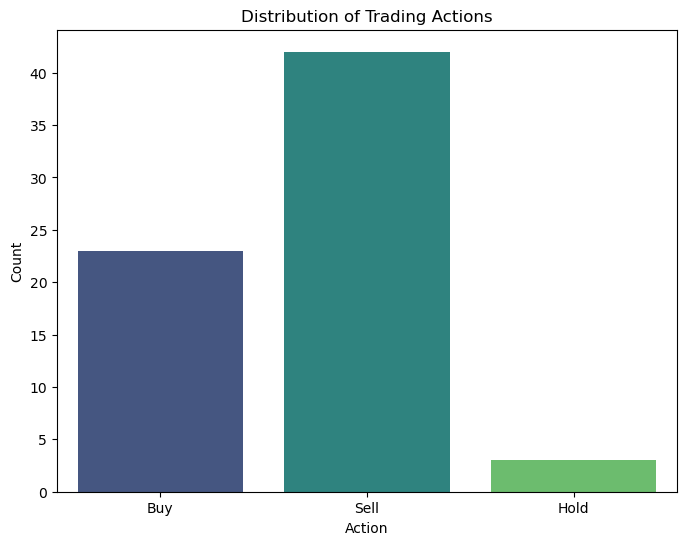

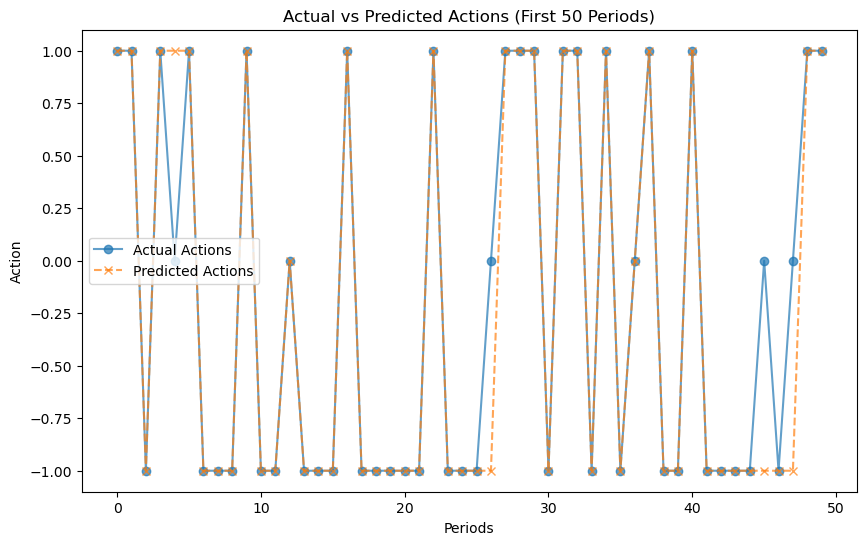

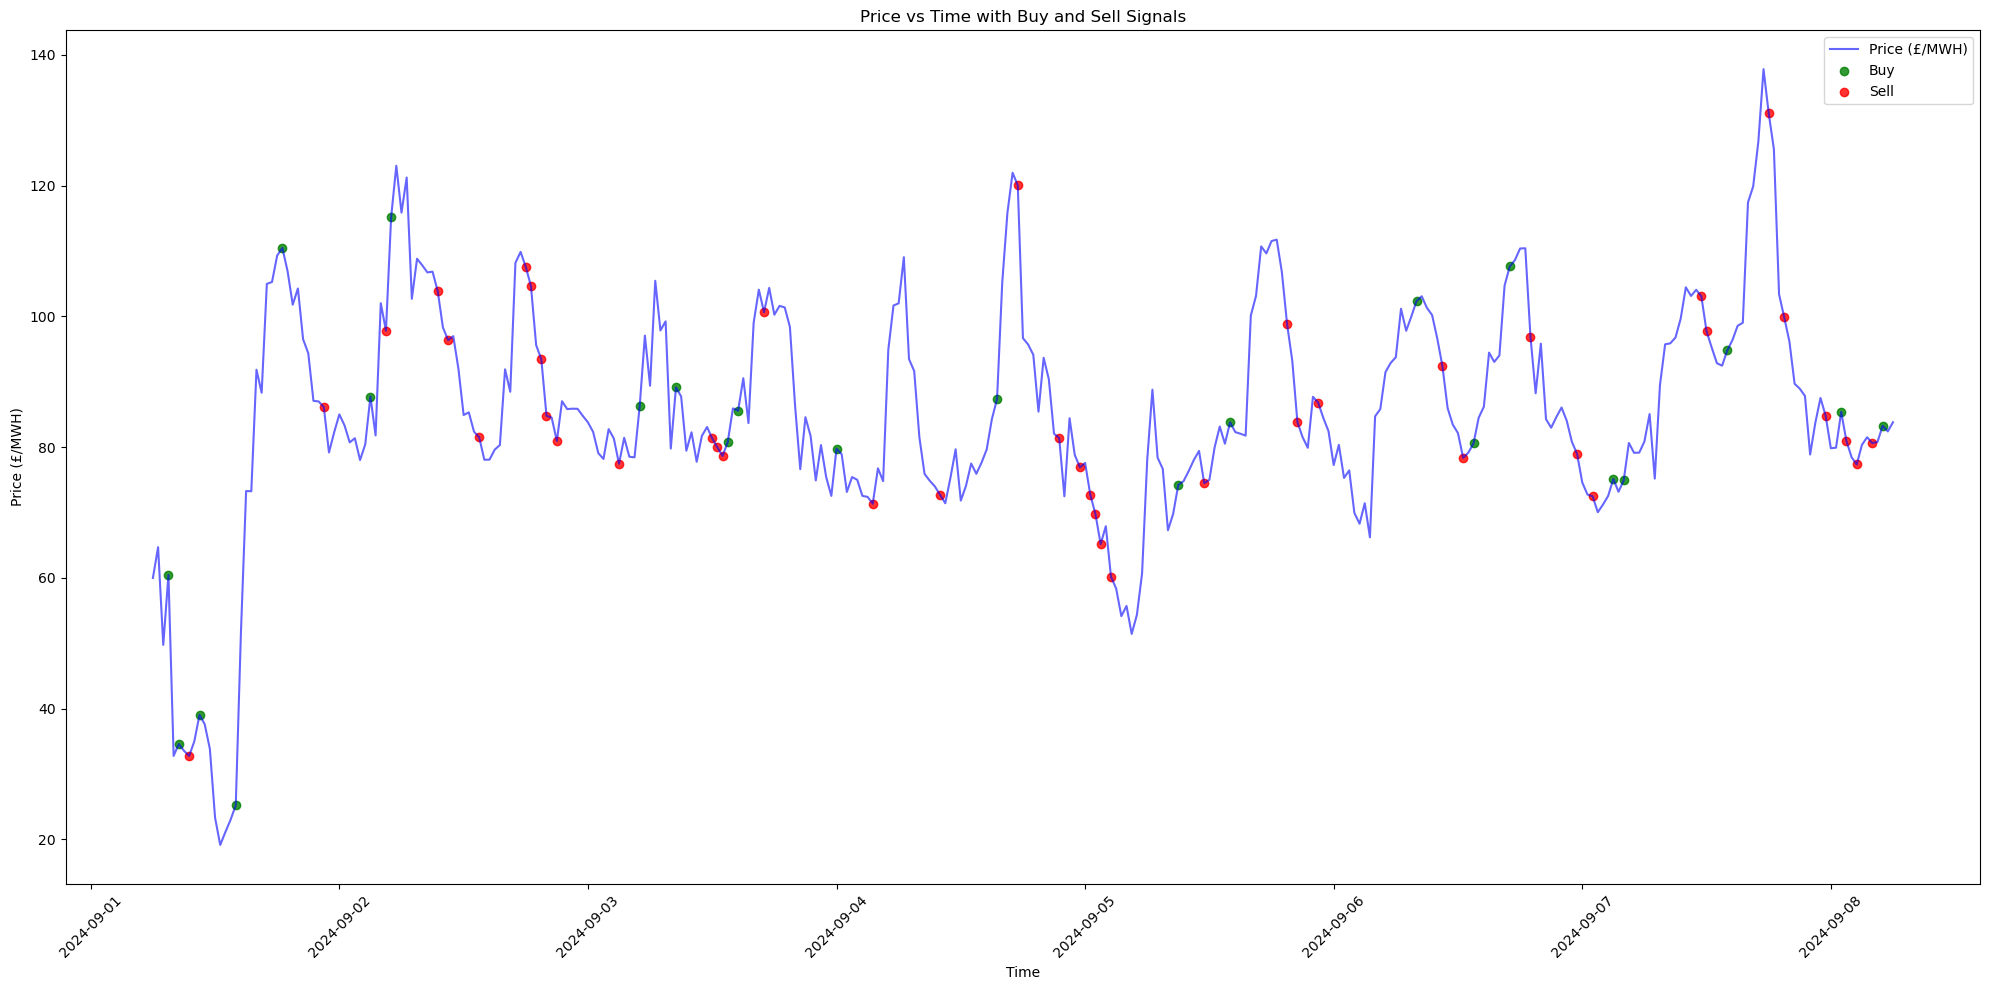

In [257]:
# Plot the distribution of actions
plt.figure(figsize=(8, 6))
sns.countplot(x=[action[1] for action in y_test_actions], hue=[action[1] for action in y_test_actions], palette='viridis', legend=False)
plt.title('Distribution of Trading Actions')
plt.xlabel('Action')
plt.ylabel('Count')
plt.show()

# Plot predicted vs actual actions comparison
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:50], label='Actual Actions', marker='o', linestyle='-', alpha=0.7)
plt.plot(y_pred[:50], label='Predicted Actions', marker='x', linestyle='--', alpha=0.7)
plt.title('Actual vs Predicted Actions (First 50 Periods)')
plt.xlabel('Periods')
plt.ylabel('Action')
plt.legend()
plt.show()

# Plot price vs time with trades indicated in chronological order
plt.figure(figsize=(20, 10))
plt.plot(df['StartTime'], df['Price(£/MWH)'], label='Price (£/MWH)', color='blue', alpha=0.6)

# Plot Buy and Sell points in chronological order
buy_signals = [action for action in y_test_actions if action[1] == 'Buy']
sell_signals = [action for action in y_test_actions if action[1] == 'Sell']

plt.scatter([x[0] for x in buy_signals], [x[2] for x in buy_signals], color='green', marker='o', label='Buy', alpha=0.8)
plt.scatter([x[0] for x in sell_signals], [x[2] for x in sell_signals], color='red', marker='o', label='Sell', alpha=0.8)

plt.title('Price vs Time with Buy and Sell Signals')
plt.xlabel('Time')
plt.ylabel('Price (£/MWH)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
